# Reforumlated Markowitz Model - Optimization Codes through Quantum Computing

### Codes to generate a single portfolio with all the constraints

Import the necessary libraries

In [16]:
import numpy as np
import pandas as pd
from dimod import ConstrainedQuadraticModel, Binary
from matplotlib import pyplot as plt
import math
import seaborn as sns

Importing the Data

In [17]:
df = pd.read_excel("Daily_Returns.xlsx")

Changing the Date to the index

In [18]:
# Convert the 'date' column to datetime format 
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

Calculating the expected returns and the variance covariance matrix

In [19]:
# Calculate expected returns for each asset
expected_returns = np.mean(df,axis=0)*252

# Calculate the variance-covariance matrix
cov_matrix = df.cov()


#Converting the expected returns to a numpy array
expected_returns = expected_returns.values

#The number of assets
n_assets = len(expected_returns)

Setting the values of the constraints

In [5]:
# Maximum acceptable risk (R): The total risk that the portfolio can assume, based on variance-covariance matrix
R = 0.1

# Maximum units of each asset that can be purchased (D)
D = 5

# Maximum number of assets in the portfolio (K): The maximum number of different assets that can be included in the portfolio
K = 15

# The number of shares the investor would like to purchase
S = 20

# Setting the value for the number of binary variables required to represent a single decision variable
M = math.floor(math.log2(S)) +1

Creating the Decision Variables

In [6]:
y = [Binary(f"y_{i}") for i in range(n_assets)] #To represent y

In [7]:
Z =  [[Binary(f"z_{i}_{l}") for l in range(M)] for i in range(n_assets)] #To represent x
# Calculate X as the weighted sum of Z's components
X = [sum(2**j * Z[i][j] for j in range(M)) for i in range(n_assets)]

Finding the weights

In [8]:
W = [x/S for x in X] 

Create the CQM Object

In [21]:
cqm = ConstrainedQuadraticModel()

Creating the Objective Function

In [10]:
H_obj = 0
for i in range(n_assets):
    H_obj -= expected_returns[i] * W[i]

Creating the risk constraint

In [11]:
# Convert the Variance Covariance matrix to a NumPy array
cov_matrix_np = cov_matrix.to_numpy()

# Convert X to a NumPy array
W_numeric = np.array(W)  

# Calculate the total variance
total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

Setting the Objective Function

In [12]:
cqm.set_objective(H_obj)

Setting the Risk Constraint

In [13]:
cqm.add_constraint_from_model(total_variance, '<=', R**2, "Variance", weight=1)

'Variance'

Adding the Linking Constraints

In [14]:
# Diversification Constraints
for i in range(n_assets):
    cqm.add_constraint_from_model(X[i] - D*y[i], '<=', 0, label=f"Linking_{i}", weight=1)

Adding the cardinality constraint

In [15]:
cqm.add_constraint_from_model(sum(y), '<=', K, label="Cardinality", weight=1)

'Cardinality'

Adding the constraint on the number of shares

In [16]:
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

'Total Shares'

Solving the optimization problem

In [20]:
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler(token="DEV-8fd91e3f0be7a8f7b1482acd4039dd1dfec169e3")  

In [ ]:
#Solve the problem
sampleset = sampler.sample_cqm(cqm)

In [19]:
print(sampleset.first) 

Sample(sample={'y_0': 0.0, 'y_1': 1.0, 'y_10': 0.0, 'y_100': 0.0, 'y_101': 0.0, 'y_102': 0.0, 'y_103': 0.0, 'y_104': 1.0, 'y_105': 0.0, 'y_106': 0.0, 'y_107': 0.0, 'y_108': 0.0, 'y_109': 0.0, 'y_11': 0.0, 'y_110': 0.0, 'y_111': 0.0, 'y_112': 0.0, 'y_113': 0.0, 'y_114': 0.0, 'y_115': 0.0, 'y_116': 0.0, 'y_117': 0.0, 'y_118': 0.0, 'y_119': 0.0, 'y_12': 0.0, 'y_120': 0.0, 'y_121': 0.0, 'y_122': 1.0, 'y_123': 0.0, 'y_124': 0.0, 'y_125': 0.0, 'y_126': 0.0, 'y_127': 0.0, 'y_128': 0.0, 'y_129': 0.0, 'y_13': 0.0, 'y_130': 1.0, 'y_131': 0.0, 'y_132': 0.0, 'y_133': 0.0, 'y_134': 0.0, 'y_135': 1.0, 'y_136': 0.0, 'y_137': 0.0, 'y_138': 1.0, 'y_139': 0.0, 'y_14': 0.0, 'y_140': 0.0, 'y_141': 0.0, 'y_142': 0.0, 'y_143': 0.0, 'y_144': 0.0, 'y_15': 0.0, 'y_16': 1.0, 'y_17': 0.0, 'y_18': 0.0, 'y_19': 0.0, 'y_2': 0.0, 'y_20': 0.0, 'y_21': 0.0, 'y_22': 0.0, 'y_23': 0.0, 'y_24': 0.0, 'y_25': 0.0, 'y_26': 1.0, 'y_27': 0.0, 'y_28': 0.0, 'y_29': 0.0, 'y_3': 0.0, 'y_30': 0.0, 'y_31': 0.0, 'y_32': 0.0, 'y_33': 

Checking for the violation of constraints

In [20]:
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)

Recreating the original decision variables

In [21]:
sample = sampleset.first[0]


# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)

decision_variables

[0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Calculating the Return

In [22]:
# Find the weights
result = [x / S for x in decision_variables]


# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, result))

print(total)

0.30520246782005817


Now let us test to see if all the constraints are satisfied

In [23]:
# Extract y values from sample
y_optimized = np.array([sample[f'y_{i}'] for i in range(n_assets)])

# Convert decision_variables to a numpy array for easy manipulation
x_optimized = np.array(decision_variables)
w_optimized = np.array(result)

# Now, checking the constraints with these values
# Constraint 1: Risk constraint
risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))
print(f"Risk Constraint Satisfied: {risk_value <= R}")
print(f"Risk Value: {risk_value} <= {R}")

# Constraint 2: Linking constraint
diversification_values = x_optimized <= D * y_optimized
print(f"Linking Constraints Satisfied: {all(diversification_values)}")

# Constraint 3: Cardinality constraint
cardinality_value = (x_optimized > 0).sum()
print(f"Cardinality Constraint Satisfied: {cardinality_value <= K}")
print(f"Number of Assets Included: {cardinality_value} <= {K}")

# Constraint 4: Non-negativity constraint
non_negativity_satisfied = all(x_optimized >= 0)
print(f"Non-negativity Constraints Satisfied: {non_negativity_satisfied}")


# Constraint 5: Sum of units
unit_sum = sum(x_optimized)
print(f"Sum of units Constraint Satisfied: {unit_sum == S}")
print(f"Number of units Included: {unit_sum} == {S}")


Risk Constraint Satisfied: True
Risk Value: 0.01771906089311505 <= 0.1
Linking Constraints Satisfied: True
Cardinality Constraint Satisfied: True
Number of Assets Included: 8 <= 15
Non-negativity Constraints Satisfied: True
Sum of units Constraint Satisfied: True
Number of units Included: 20.0 == 20


Checking the assets to invest in

In [24]:
values_list = x_optimized.tolist()

# Creating a new DataFrame with column names and values where values are > 0
filtered_data = {'Asset': [], 'Value': []}
for column_name, value in zip(df.columns, values_list):
    if value > 0:
        filtered_data['Asset'].append(column_name)
        filtered_data['Value'].append(value)

new_df = pd.DataFrame(filtered_data)

print(new_df)

  Asset  Value
0  AAPL    3.0
1  ALGN    3.0
2  ANSS    1.0
3  BKNG    3.0
4   DHI    2.0
5   KMX    2.0
6  NFLX    3.0
7  TSLA    3.0


### Generating many portfolios for the efficient frontier

Generating the constraint limits

In [22]:
#Sum of shares
S = 1000

#Number of binary variables neded to represent X
M = math.floor(math.log2(S)) +1

Getting the variables ready

In [24]:
Z = [[Binary(f"z_{i}_{l}") for l in range(M)] for i in range(n_assets)] #To represent x
X = [sum(2**j * Z[i][j] for j in range(M)) for i in range(n_assets)] # Calculate X as the weighted sum of Z's components
W = [x/S for x in X] #For the weight

Getting the objective function

In [25]:
H_obj = 0
for i in range(n_assets):
    H_obj -= expected_returns[i] * W[i]

Getting the risk function

In [26]:
# Convert the Variance Covariance matrix to a NumPy array
cov_matrix_np = cov_matrix.to_numpy()

# Convert X to a NumPy array
W_numeric = np.array(W)  

# Calculate the total variance
total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

Generating the portfolio with the highest returns

In [27]:
# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(H_obj)

#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

#Solve the problem
sampleset = sampler.sample_cqm(cqm)

#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)

#Recreating the decision variables
sample = sampleset.first[0]

# Reconstruct the original decision variables
decision_variables = []
for i in range(n_assets):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)

# Find the weights
weights = [x / S for x in decision_variables]

# Multiply corresponding elements and sum them up for the return
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized_max_return = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized_max_return = np.array(weights)

# Risk Value
risk_value_maximum_return = np.sqrt(np.dot(np.dot(w_optimized_max_return.T, cov_matrix), w_optimized_max_return))

print("The number of units to buy: ")
print(x_optimized_max_return)
print("SUM OF WEIGHTS:",sum(w_optimized_max_return))
print("Risk: ", risk_value_maximum_return)
print("Return: ", total)

The number of units to buy: 
[ 0. 31.  1.  1. 23.  7.  4.  2. 15. 13.  0.  8.  0.  4.  4. 12. 31.  6.
 13.  0.  3. 31.  2. 14. 14.  0. 31.  3.  5.  5.  5.  0.  4.  4.  5. 15.
  0.  1. 15.  3.  0.  0.  6.  1.  1.  5. 11.  0. 30.  0.  5.  0.  7.  0.
  0.  3.  0.  0.  0.  0.  7.  3.  2. 15. 13.  0.  7.  1. 10. 31.  0.  4.
  6.  0.  3.  0.  0.  0.  0.  0.  6. 30.  7.  0. 17.  1.  0. 10.  9.  7.
  0.  0. 39.  0.  7. 11. 15.  0.  0.  0.  3. 11.  0.  0. 19.  4.  0.  9.
  3. 31. 15.  1. 31.  0.  2.  0. 13. 15.  1.  0.  0. 15. 31.  0. 11.  0.
  4.  4.  0.  0. 47.  4.  0.  0.  0.  0. 15.  0. 15. 31.  0.  0.  0.  0.
  0.]
SUM OF WEIGHTS: 1.0000000000000007
Risk:  0.013060573835447627
Return:  0.2273359023178134


Calculating the portolio with the lowest risk

In [28]:
# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(total_variance)

#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

#Solve the problem
sampleset = sampler.sample_cqm(cqm)

#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)

#Recreating the decision variables
sample = sampleset.first[0]

# Reconstruct the original decision variables
decision_variables = []
for i in range(n_assets):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)

#Calculating the total return
# Find the weights
weights = [x / S for x in decision_variables]

# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized_MIN_RISK = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized_MIN_RISK = np.array(weights)

# Risk Value
risk_value_minimum = np.sqrt(np.dot(np.dot(w_optimized_risk_value.T, cov_matrix), w_optimized_risk_value))

print("The number of units to buy: ")
print(x_optimized_risk_value)
print("SUM OF WEIGHTS:",sum(w_optimized_MIN_RISK))
print("Risk: ", risk_value_minimum)
print("Return: ", total)

The number of units to buy: 
[ 0.  1. 31.  4.  0.  0.  1.  3.  0.  0.  0.  0.  2.  3.  0.  0.  0.  0.
  1. 55.  0.  0.  1.  1.  0. 23.  1.  1.  0.  1.  0. 23.  0. 15.  2.  5.
  0.  0.  7.  0.  0.  7.  0.  7.  3.  1.  3.  0.  0.  0.  0. 15. 23. 14.
  0.  0.  0.  0. 23.  2.  0.  0. 63.  0.  3.  0.  0. 31.  0.  3. 31. 15.
  7. 63.  0.  0. 11. 63.  0.  1.  3.  7.  0.  7.  3.  7.  0.  5.  0.  7.
 23. 23.  1.  0.  0.  0.  0. 31.  3.  0.  0.  0.  0. 31.  0.  1.  0.  7.
  0.  0. 14.  0.  0. 63.  3.  0.  4. 20.  0.  0. 15.  0.  0.  7.  7. 23.
  7. 15.  7.  1.  5.  3. 15.  7.  7.  0.  6. 11.  3.  1.  1.  7. 11.  0.
  8.]
SUM OF WEIGHTS: 1.0000000000000002
Risk:  0.007366923226249205
Return:  0.11505191324449202


Calculating the efficient frontier

In [30]:
# Initialize arrays to store portfolio returns, volatilities, and weights
num_ports = 50

# Calculate the gap between portfolio volatilities for equally spaced portfolios
vol_min = risk_value_minimum
vol_max = risk_value_maximum_return
gap = (vol_max - vol_min) / (num_ports)

# Maximum acceptable risk (R): The total risk that the portfolio can assume, based on variance-covariance matrix
Variance_Values = [(vol_min + gap*i) for i in range(num_ports)]

In [31]:
"""

We will now loop over multiple risk values to calculate the return and get an efficient frontier and generate
each of the portfolios for these risk values. Note that all the constraints except the number of shares the investor should invest
in and the risk value would be relaxed in this solution for the purpose of comparing with the vanilla markowitz model.

"""

results_list = []  # Initialize the list

for R in Variance_Values:

    # Check the variance value
    print(R)

    # Create the CQM Object
    cqm = ConstrainedQuadraticModel()

    #Adding the objective function
    cqm.set_objective(H_obj)

    # Add risk constraints
    cqm.add_constraint_from_model(total_variance, '<=' ,(R)**2, label="Max Risk",weight=float('inf'))
    
    #Adding the sum of shares constraint
    cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

    #Solving the problem
    sampleset = sampler.sample_cqm(cqm)

    #Checking for violations
    for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
        print(label, violation)

    #Recreating the decision variables
    sample = sampleset.first[0]

    # Reconstruct the original decision variables
    decision_variables = []
    for i in range(n_assets):
        value = 0
        for j in range(M): 
            bit_value = sample[f'z_{i}_{j}']
            value += 2**j * bit_value
        decision_variables.append(value)

    #Calculating the total return

    # Find the weights
    weights = [x / S for x in decision_variables]

    # Multiply corresponding elements and sum them up
    total = sum(x * y for x, y in zip(expected_returns, weights))

    # Convert decision_variables to a numpy array for easy manipulation
    x_optimized = np.array(decision_variables)

    # Convert weights to a numpy array for easy manipulation
    w_optimized = np.array(weights)

    # Constraint 1: Risk constraint
    risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))

    # Constraint 2: Sum of shares constraint
    sum_of_shares_satisfied = sum(x_optimized) == S

    #Creating the asset dataframe
    values_list = x_optimized.tolist()

    # Creating a new DataFrame with column names and values where values are > 0
    filtered_data = {'Asset': [], 'Value': []}
    for column_name, value in zip(df.columns, values_list):
        if value > 0:
            filtered_data['Asset'].append(column_name)
            filtered_data['Value'].append(value)

    # Create a dictionary for the current iteration
    iteration_results = {
        'risk_value': risk_value,
        'R': R,
        'total_return': total,
        'risk_constraint_satisfied': risk_value <= R,
        'Total_Shares_satisfied': sum_of_shares_satisfied,
        'assets_included_df': filtered_data
    }



    # Step 4: Append this dictionary to the list
    results_list.append(iteration_results)

0.007366923226249205
Max Risk 2.2823093620551695e-05
0.007480796238433174
Max Risk 0.00021022373799723507
0.007594669250617142
Max Risk 1.2696535046314845e-05
0.00770854226280111
Max Risk 8.521113336066486e-05
0.007822415274985079
Max Risk 1.6503416913808233e-08
0.007936288287169047
Max Risk 0.00020992809526468575
0.008050161299353016
Max Risk 0.00016236413961378737
0.008164034311536984
Max Risk 0.00041784392538438977
0.008277907323720952
Max Risk 0.00019095161827890357
0.008391780335904922
Max Risk 0.0001776985755235251
0.00850565334808889
Max Risk 8.685846853065648e-07
0.008619526360272857
Max Risk 0.00031313725961110026
0.008733399372456827
Max Risk 0.0002651398109963171
0.008847272384640795
Max Risk 0.00014454556756006025
0.008961145396824763
Max Risk 0.00019028493926361525
0.009075018409008732
Max Risk 0.00014749522185006223
0.0091888914211927
Max Risk 0.0002439847864338259
0.00930276443337667
Max Risk 4.2292283300980095e-08
0.009416637445560637
Max Risk 0.00010064177936292739
0.0

Creating a dataframe of results

In [32]:
# Creating a DataFrame from results_list for specific metrics
metrics_columns = [
    'risk_value',
    'R',
    'total_return',
    'risk_constraint_satisfied',
    'Total_Shares_satisfied'
]

# Use a list comprehension to pick out these specific keys from each dictionary in the results list
final_results_data = [{col: result[col] for col in metrics_columns} for result in results_list]

# Convert this list of dictionaries to a DataFrame
final_results_df = pd.DataFrame(final_results_data)

# Save the DataFrame as an Excel file
final_results_df.to_excel('Final_Results.xlsx', index=False)


Plotting the efficient frontier

In [37]:
#Calculating the sharpe ratio
final_results_df["Sharpe_Ratio"]=final_results_df["total_return"]/final_results_df["risk_value"]

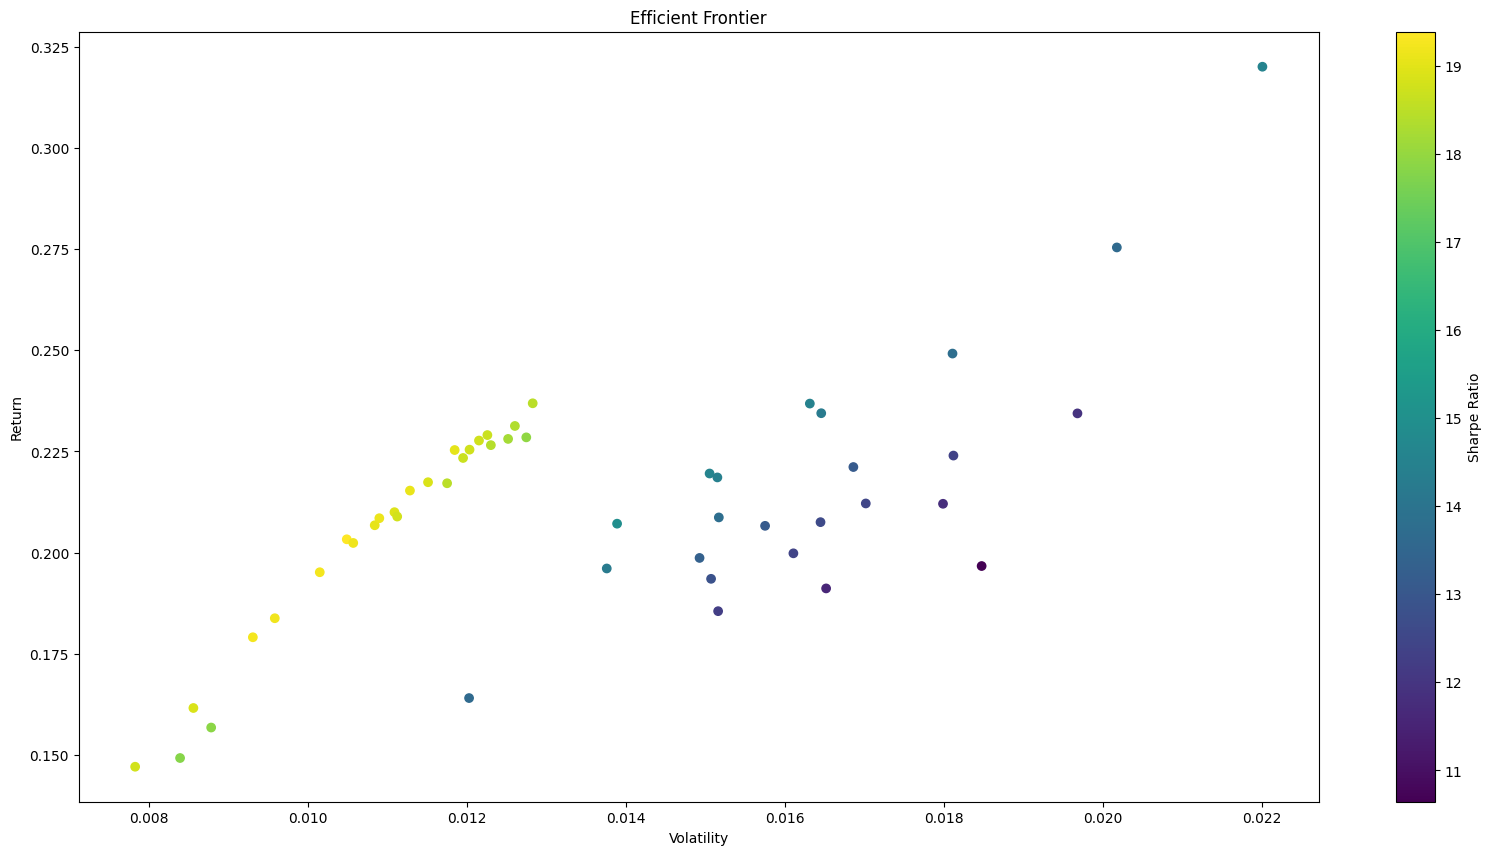

In [39]:

# Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(final_results_df["risk_value"], final_results_df["total_return"], c=final_results_df["Sharpe_Ratio"], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


Reformulating and plotting the efficient frontier

In [53]:
"""

Sometimes QC gives us suboptimal solutions. Hence, each return with a higher risk value
will be compared with the return of the risk value just below that and discarded if it has a lower
return. If not the data point would be kept. In this way, we will create a new dataframe for a cleaner
efficient frontier

"""

# Sorting the DataFrame by 'risk_value'
final_results_df = final_results_df.sort_values(by='risk_value')

# Filtering the DataFrame based on the 'total_return' condition
filtered_df = pd.DataFrame()
last_valid_return = -float('inf')  # Initialize to negative infinity

for index, row in final_results_df.iterrows():
    if row['total_return'] > last_valid_return:
        filtered_df = pd.concat([filtered_df, pd.DataFrame([row])])
        last_valid_return = row['total_return']

# Resetting the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

filtered_df = filtered_df[["risk_value","total_return"]]


In [44]:
#Calculating the sharpe ratio
filtered_df["Sharpe_Ratio"]=filtered_df["total_return"]/filtered_df["risk_value"]

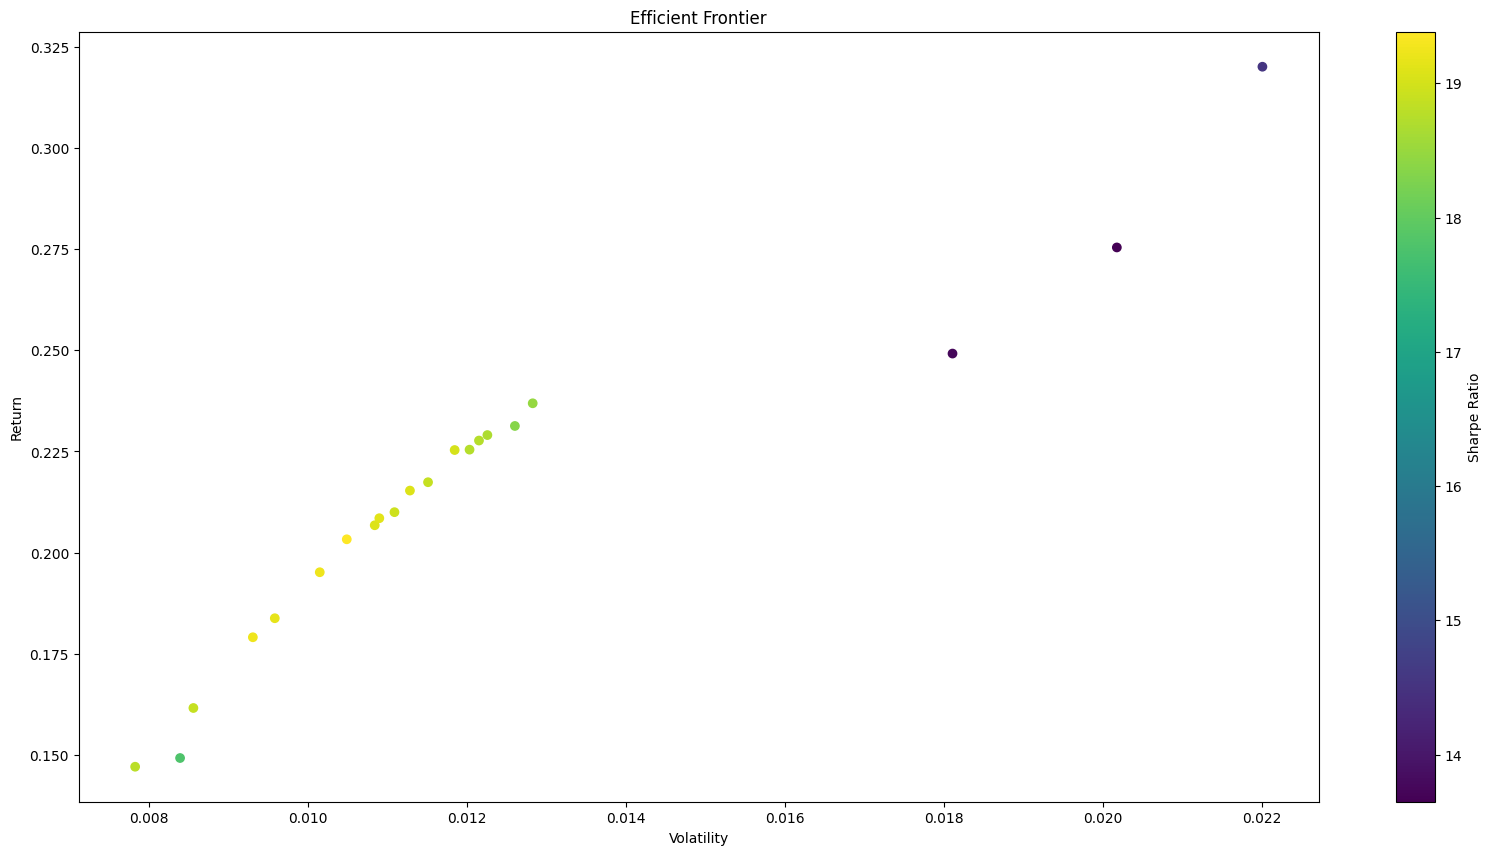

In [51]:

# Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(filtered_df["risk_value"], filtered_df["total_return"], c=filtered_df["Sharpe_Ratio"], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


Adding a curve to the efficient frontier

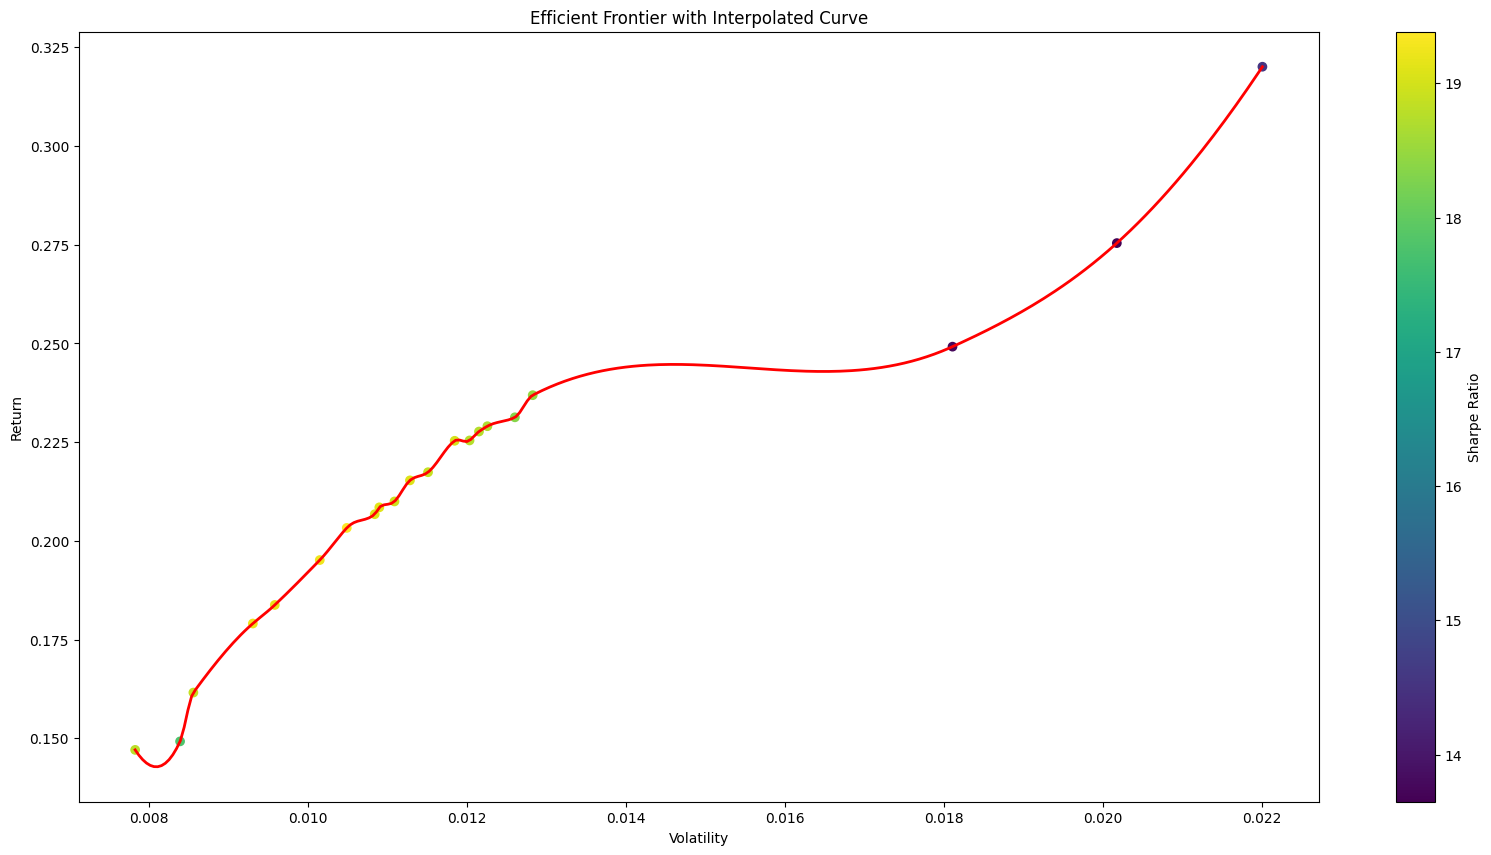

In [52]:
from scipy.interpolate import Akima1DInterpolator

# RRenaming the dataframw
df_reformulated = filtered_df

# Create the Akima interpolator
akima_interpolator = Akima1DInterpolator(df_reformulated['risk_value'], df_reformulated['total_return'])

# Generate more x values for a smooth curve
x_fine = np.linspace(df_reformulated['risk_value'].min(), df_reformulated['risk_value'].max(), 300)

# Evaluate the interpolator to get y values
y_fine = akima_interpolator(x_fine)

plt.figure(figsize=(20, 10))

# Scatter plot of the original data points
plt.scatter(df_reformulated["risk_value"], df_reformulated["total_return"], c=df_reformulated["Sharpe_Ratio"], cmap='viridis')

# Plot the smooth curve
plt.plot(x_fine, y_fine, 'r-', linewidth=2)  

# Adding a colorbar
plt.colorbar(label='Sharpe Ratio')

# Labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier with Interpolated Curve')
plt.show()


Creating the portfolio with risk 1%

In [55]:
# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(H_obj)

#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=5)

# Add risk constraints
cqm.add_constraint_from_model(total_variance, '<=' ,(0.01)**2, label="Max Risk",weight=float('inf'))

#Solve the problem
sampleset = sampler.sample_cqm(cqm)

#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)

#Recreating the decision variables
sample = sampleset.first[0]

# Reconstruct the original decision variables
decision_variables = []
for i in range(n_assets):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)

# Find the weights
weights = [x / S for x in decision_variables]

# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized = np.array(weights)

# Risk Value
risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))

print("The number of units to buy: ")
print(x_optimized)
print("SUM OF WEIGHTS:",sum(w_optimized))
print("Risk: ", risk_value)
print("Return: ", total)

Max Risk 1.2349153604447588e-06
The number of units to buy: 
[ 0.  7. 12.  7.  8.  0.  4.  0.  1.  2.  0.  0.  2.  5.  1.  2. 12.  2.
  4.  8.  0. 18.  4. 15.  0. 55.  7.  1.  0.  2. 19.  0.  2. 24.  4. 15.
  0.  0. 15.  0.  0.  2.  2.  7.  1.  8.  5.  0.  1.  0. 11.  3. 17. 14.
  0.  0.  0.  0.  1.  2.  1.  4.  5.  0.  1.  0.  0.  7.  0. 19. 10. 15.
  3.  2. 10.  0.  0.  4.  0.  0. 15. 15.  7.  0. 35. 14.  0. 15.  3. 23.
  0. 11. 23.  0.  3.  2.  3.  4.  0.  2.  0.  2.  0. 18.  7.  3.  0.  5.
 11. 14. 31.  0.  6.  4.  7.  0. 15.  7.  0.  0.  1.  0. 31.  1. 23.  7.
  6. 29.  0.  1. 23.  0. 24.  0.  1.  0. 21.  0. 55. 45.  1.  8.  0.  4.
  1.]
SUM OF WEIGHTS: 1.0000000000000007
Risk:  0.010061556309062943
Return:  0.1949839484349116


Creating the asset allocation chart

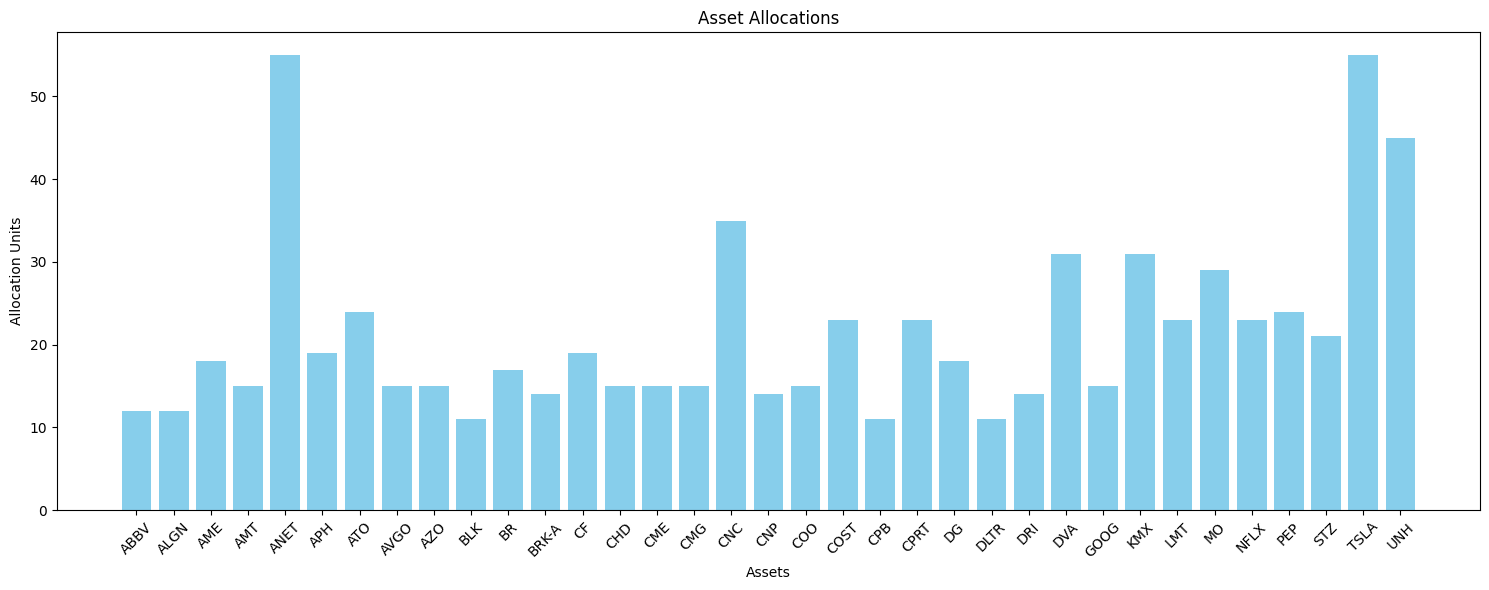

In [58]:
column_names = df.columns.tolist()

# Filter the weights and corresponding names for weights > 0
filtered_weights = [x for x in x_optimized if x > 10.0]
filtered_names = [column_names[i] for i, x in enumerate(x_optimized) if x > 10.0]
# Plotting the bar chart
plt.figure(figsize=(15, 6)) 
plt.bar(filtered_names, filtered_weights, color='skyblue') 
plt.xlabel('Assets')  # Adding x-label
plt.ylabel('Allocation Units')  # Adding y-label
plt.title('Asset Allocations')  # Adding title
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability if names are long
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Creating the correlation heatmap

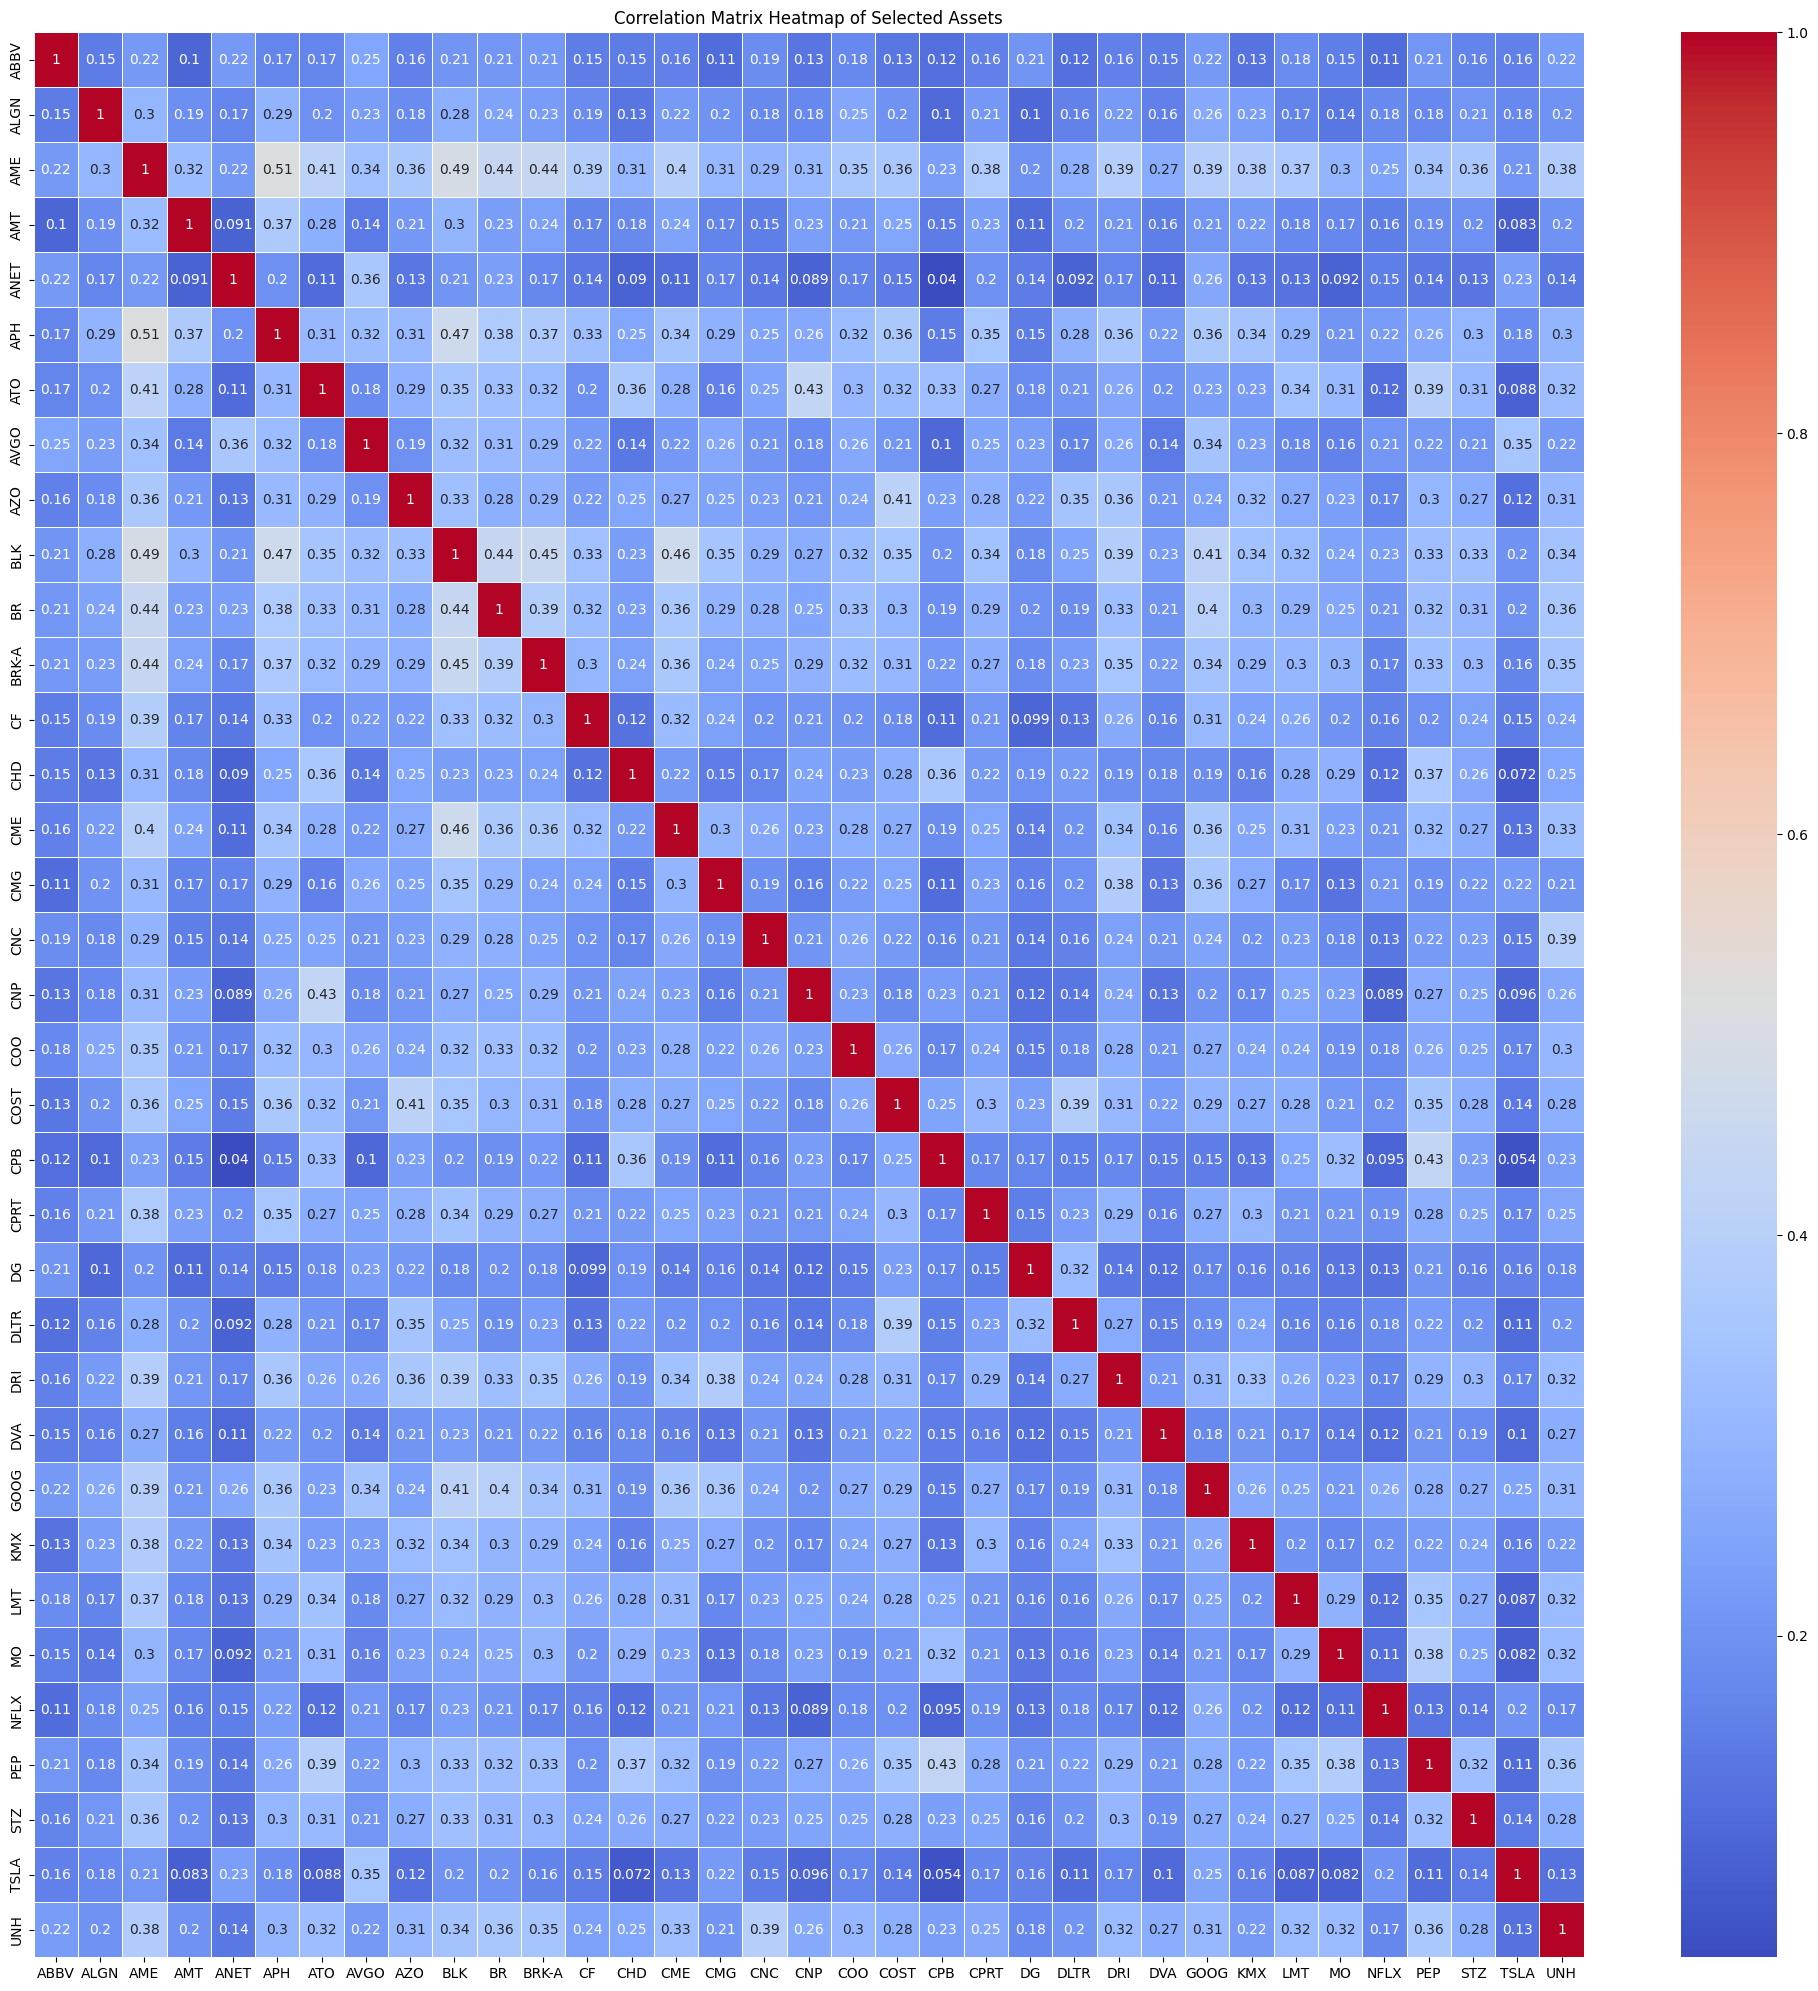

In [61]:
# Filter columns in df where the corresponding weight in w_min is greater than 0
filtered_df = df[filtered_names]

# Compute the correlation matrix
corr_matrix = filtered_df.corr()

# Plot the heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap of Selected Assets')
plt.show()


Now let us create a dataframe of results

In [60]:
# Append the values to the DataFrame
new_row = pd.DataFrame({'return': [total], 'risk': [risk_value]})

#Save the dataframe
new_row.to_excel("Quantum_Results.xlsx",index=False)